### Optimize 0D adult physiology model under heart failure conditions

**Author**: Daniele E. Schiavazzi

**Date**: June 28th, 2017

**Objectives of this tutorial**:
- Learn how to create **data** objects in tulip.
- Learn how to create **0D models and ODE integrators** in tulip.
- Learn how to create actions in tulip to **optimize models** according to collected data.

First, lets create a **daData_multiple_Table** tulip data object. This simply means that patient data will be store by row where each patient occupies a separate column.

In [16]:
# Import tulip
import sys
sys.path.insert(0, '/home/dschiava/Development/CApps/tulipApp/libBin/py')
import numpy as np
import matplotlib.pyplot as plt
# Import UQ Library
import tulipUQ as uq
# Import Computational Model Library
import tulipCM as cm
# Import Data Library
import tulipDA as da
# Import Action Library
import tulipAC as ac

# READ DATASET
data = da.daData_multiple_Table()
data.readFromFile('heartFailure.dat')

print np.loadtxt('heartFailure.dat',delimiter=',',dtype=str)

[['RAP' '15.0' '9.0' '4.0']
 ['sPAP' '50.0' '35.0' '20.0']
 ['dPAP' '25.0' '19.0' '12.0']
 ['PWP' '25.0' '17.0' '9.0']
 ['SBP' '120.0' '120.0' '120.0']
 ['DBP' '80.0' '80.0' '80.0']
 ['SVR' '1800' '1575.0' '1350.0']
 ['CO' '3.5' '4.375' '5.25']]


The columns in the above data table represent patients affected by diastolic left ventricular disfunction. Patients with normal, mild and severe left ventricular diastolic dysfunction are represented in columns 4, 3 and 2, repectively. As expencted the systemic indicators (Systemic Blood Pressures "SBP","DBP" and Cardiac Output "CO") are not significantly affected by this condition.

Let's start by creating a ODE circuit model. tulip provides a library of existing models, the odeNormalAdultSimplePA is an adult model with normal physiology and is characterized by a simple RC pulmonary compartment.

In [17]:
# CREATE ODE MODEL
ode = cm.odeNormalAdultSimplePA()

We now create a Runge-Kutta 4 ODE integrator and initialize it by providing the ODE model as weel as the integration time step and total number of heart cycles. 
Note that the ODE model knows about its own heart rate (one of the model parameters) and therefore the total number of time steps is automatically selected to consistently generated the same number of heart cycles.

In [18]:
# CREATE ODE INTEGRATOR
timeStep = 0.01
totalCycles = 10
rk4 = cm.odeIntegratorRK4(ode,timeStep,totalCycles)

An LPN (lumped parameter network) model is initialized by providing the selected ODE integrator.

In [19]:
# Create new LPN model
lpnModel = cm.cmLPNModel(rk4)

The cmLPNModel contains a data object that knows how to compute cost functions and likelihoods. This object needs to be assigned before we can proceed. The second argument represents the specific column of the patient data file that we would like to use for optimization.

In [20]:
# ASSIGN DATA OBJECT TO MODEL
lpnModel.setData(data,0)

Once we are happy with the model and data, we need to decide what to do with them. One possibility is to do optimization . We first define some parameters and then initialize the acActionOPT_NM to perform optimization using the Nelder-Mead algorithm.

The following parameters are used:
- **totIterations** is the total number of restart for ther Nelder-Mead optimizer. While the Nelder-Mead algorithm is often used for its robustness, restarts are sometime necessary to recover from situations where the simplex degenerates. In practice we notice that restart help in our case, leading to progressively smaller and smaller log-likelihood. 
- **convTol** is the convergence tolerance.
- **convUpdateIt** is the number of iteration between convergence checking.
- **maxOptIt** is the maximum number of function evaluations
- **stepCoefficient** determines the size and shape of the initial simplex. The relative magnitudes of its elements should reflect the units of the variables.

This algorithm has been modified from the implementation at [this link](http://people.sc.fsu.edu/~jburkardt/cpp_src/asa047/asa047.html).

**References**:
- Nelder J., Mead R., *A simplex method for function minimization*, Computer Journal, Volume 7, 1965, pages 308-313.
- O'Neill R., *Algorithm AS 47: Function Minimization Using a Simplex Procedure,Applied Statistics*, Volume 20, Number 3, 1971, pages 338-345.


In [26]:
# SET OPTIMIZER PARAMETERS
# Total Number of iterations
totIterations   = 10
# Convergence Tolerance
convTol         = 1.0e-6
# Check Convergence every convUpdateIt iterations
convUpdateIt    = 1
# Maximum Iterations
maxOptIt        = 200
# Coefficient for Step increments
stepCoefficient = 0.1

# INIT ACTION
nm = ac.acActionOPT_NM(convTol,convUpdateIt,maxOptIt,stepCoefficient)

At this point, we assign the LPN model to the acAction object.

In [27]:
# ASSIGN MODEL TO ACTION
nm.setModel(lpnModel)

With this assignment we have **completely defined the object hierarchy in tulip**. Specifically, the model has a data member that, based on the model result, evaluate the likelihood or cost function and the optimizer knows which model to run. This hierarchy is summarized in the picture below:


<img src="tulip.png" width="50%" height="50%">

We set the initial guess to the default parameter set.

In [28]:
# SET INITIAL GUESS - DEFAULT PARAMETER VALUES
useStartingParameterFromFile = False
startFromCentre              = False
startParameterFile           = ''
nm.setInitialParamGuess(useStartingParameterFromFile,startFromCentre,startParameterFile)

We solve totIteration restarts using this loop. Note that the optimization is started by calling **nm.go()**. The action knows 

In [29]:
# RUN RESTARTED NELDER-MEAD
for loopA in range(totIterations):      
  # PERFORM ACTION
  nm.go()
  # SET RESTART CONDITION
  if(loopA == 0):
    nm.setInitialPointFromFile(True)
    nm.setInitialPointFile('optParams.txt')
print '--- Iteration Completed!!'

--- Iteration Completed!!


Check the agreement between the patient data and the outputs of the optimized model. Let's open the **outputTargets.out** file that contains this information.

In [30]:
print np.loadtxt('outputTargets.out',delimiter=',',dtype=str)

['            Key        Measured        Computed          Weight'
 '            SBP         120.000         118.163           1.000'
 '            DBP          80.000          82.961           1.000'
 '            RAP          15.000           1.956           1.000'
 '           sPAP          50.000          26.660           1.000'
 '           dPAP          25.000          19.580           1.000'
 '            PWP          25.000           7.551           1.000'
 '             CO           3.500           4.909           1.000'
 '            SVR        1800.000        1585.964           1.000']


The **allData.dat** file has also been generated with the model outputs for all the time steps. Lets plot some pressures, flows and pressure-volume loops.

// Store the derivatives
  DXk[0] = V_ra_p;
  DXk[1] = V_la_p;
  DXk[2] = V_rv_p;
  DXk[3] = V_lv_p;
  DXk[4] = Q_ra_rv_p;
  DXk[5] = P_pa_p;
  DXk[6] = Q_rv_pa_p;
  DXk[7] = Q_la_lv_p;
  DXk[8] = P_ao_p;
  DXk[9] = Q_lv_ao_p;
  DXk[10] = P_sys_p;

  // Get Auxiliary Results
  auxOut[0]  = t;       // Current Time
  auxOut[1]  = tcr;     // Relative Cycle Time
  auxOut[2]  = fAA;     // Atrial Activation Function
  auxOut[3]  = fAV;     // Right Ventricle Elastance
  auxOut[4]  = 0.0;
  auxOut[5]  = P_ra;    // Right Atrial Pressure
  auxOut[6]  = P_la;    // Left Atrial Pressure
  auxOut[7]  = P_rv;    // Right Ventricular Pressure
  auxOut[8]  = P_lv;    // Left Ventricular Pressure
  auxOut[9]  = Q_pul;   // Pulmonary flow rate
  auxOut[10] = Q_sys_a; // Systemic flow Rate - Arteries
  auxOut[11] = Q_sys_v; // Systemic flow Rate - Veins
  auxOut[12] = Ind[4];  // RA-RV valve status
  auxOut[13] = Ind[6];  // RV-PA valve status
  auxOut[14] = Ind[7];  // LA-LV valve status
  auxOut[15] = Ind[9];  // LV-AO valve status

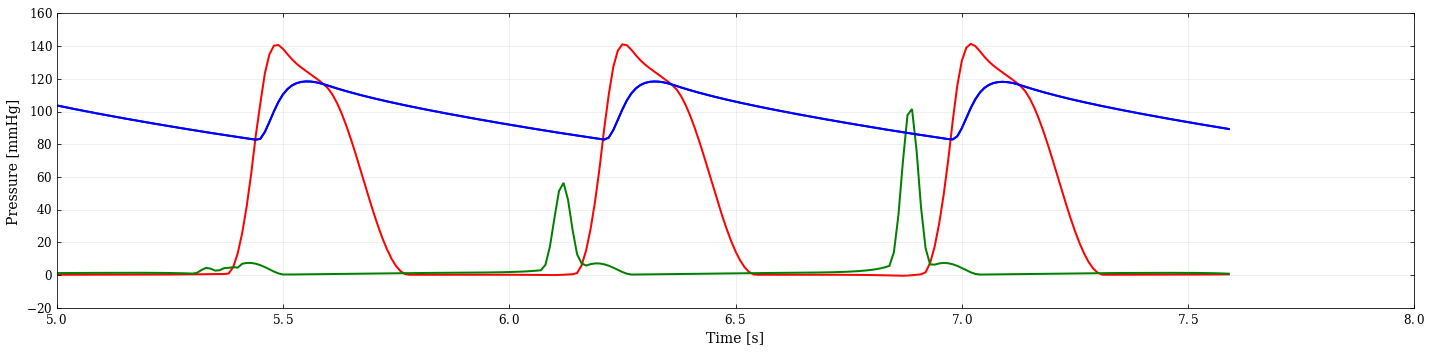

In [31]:
res = np.loadtxt('allData.dat')
ini = 500
# PLOT CONTENT
plt.figure(figsize=(20,5))
# Pressure Curves
plt.subplot(1,1,1)
plt.plot(res[ini:,11],res[ini:,19]/1333.3,'r-',lw=2) # Left Ventricular Pressure
plt.plot(res[ini:,11],res[ini:,17]/1333.3,'g-',lw=2) # Left Atrial Pressure
plt.plot(res[ini:,11],res[ini:,8]/1333.3,'b-',lw=2) # Aortic Pressure
plt.plot(res[ini:,11],res[ini:,8]/1333.3,'b-',lw=2) # Pulmonary Pressure
plt.xlabel('Time [s]',fontsize=14)
plt.ylabel('Pressure [mmHg]',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.tight_layout()
plt.show()

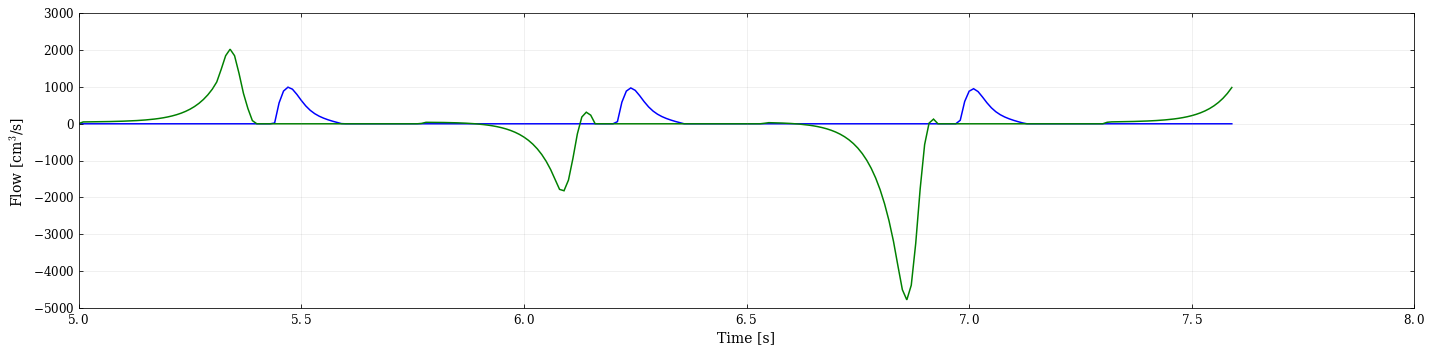

In [36]:
# Flow Curves
plt.figure(figsize=(20,5))
plt.subplot(1,1,1)
plt.plot(res[ini:,11],res[ini:,9]) # Aortic Flow
plt.plot(res[ini:,11],res[ini:,7]) # Left atrioventricular flow
plt.xlabel('Time [s]',fontsize=14)
plt.ylabel('Flow [cm$^3$/s]',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.tight_layout()
plt.show()

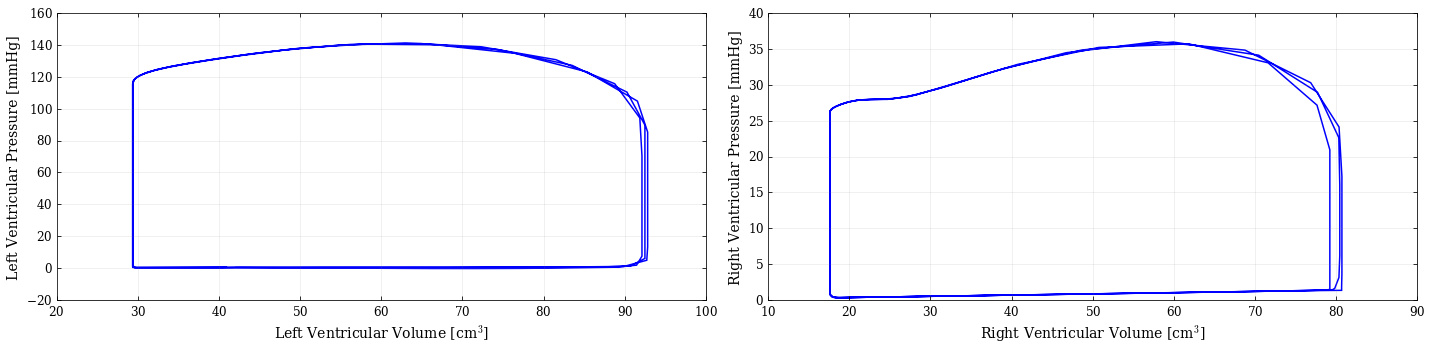

In [35]:
# Ventricular Pressure-Volume
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(res[ini:,3],res[ini:,19]/1333.3) # Left Ventricular PV Loop
plt.xlabel('Left Ventricular Volume [cm$^3$]',fontsize=14)
plt.ylabel('Left Ventricular Pressure [mmHg]',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.subplot(1,2,2)
plt.plot(res[ini:,2],res[ini:,18]/1333.3) # Right Ventricular PV Loop
plt.xlabel('Right Ventricular Volume [cm$^3$]',fontsize=14)
plt.ylabel('Right Ventricular Pressure [mmHg]',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.tight_layout()
plt.show()